In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [17]:
folder = "/home/ovs2/lining/automatic/"
toponame = "Topology-incast-singlenode.tcl"
flownum = 100
loads = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95]
algs = ["AFQ10", "PQ", "HRCC", "DropTail", "AFQ100", "AFQ1000"]


In [18]:
def parse_trace(dir, filename):
    col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
               "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
    df = pd.read_csv(dir+filename, sep = ' ', header = None)
    df.columns = col
    df["Normalized FCT"] = 1/df["Average rate"]
    return df

In [19]:
def show_diff_duration_and_(df):
    # bytes
    flow_size = df['tmp_pkts'] * 1500 * 8 / df['Average rate'] 
    flow_size.plot()
    df['flow duration'].plot()

In [20]:
def plotting_FCT(loads, algs, raw_data):
    plt.figure(figsize=(8,5))
    plt.xlabel("Link utilization")
    plt.ylabel("Normalized FCT")
    plt.title("Normalized FCT")
    for alg_i in range(len(algs)):
        alg = algs[alg_i]
        load_means = [0 for i in range(len(loads))]
        for load_i in range(len(loads)):
            load = loads[load_i]
            load_means[load_i] = raw_data[alg_i][load_i]["Normalized FCT"].mean()
        plt.plot(loads, load_means, label=alg)
    plt.legend(loc='best')
    plt.show()

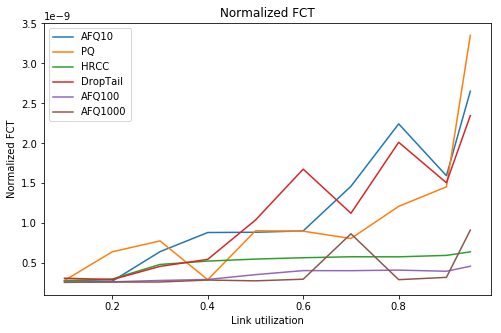

In [21]:
raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
for alg_i in range(len(algs)):
    for load_i in range(len(loads)):
        alg = algs[alg_i]
        load = loads[load_i]
        raw_data[alg_i][load_i] = \
            parse_trace(folder, filename = "tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
        # show_diff_duration_and_(raw_data)
plotting_FCT(loads, algs, raw_data)